In [2]:
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid", font_scale=1.25)

In [61]:
with open("../results/theta/results-128.jsonl") as fp:
    lines = fp.readlines()
experiments = [json.loads(line) for line in lines]
results = pd.DataFrame.from_records(experiments)
results.loc[results["method"] == "lazy", "method"] = "ProxyImports"
results

,ntasks,cumulative_time,times,launch_time,end_time,method,module,nodes,sleep,setup
0,8192,167447.268475,"[19.991256164968945, 15.567781917052343, 19.76...",6.471389,240.388414,ProxyImports,numpy,128,10,6.170360
1,4096,71223.936740,"[16.763518185936846, 16.851553721004166, 15.63...",3.310375,117.473986,ProxyImports,numpy,128,10,4.950776
2,2048,36255.267539,"[17.22222698596306, 17.467857328942046, 17.652...",1.641536,75.757421,ProxyImports,numpy,128,10,4.319023
3,1024,18163.464681,"[17.466079031000845, 17.383916473016143, 17.83...",0.922223,130.296993,ProxyImports,numpy,128,10,4.584375
4,512,9087.955938,"[17.628573889029212, 17.628335727960803, 17.62...",0.418922,46.542825,ProxyImports,numpy,128,10,4.277192
...,...,...,...,...,...,...,...,...,...,...
63,2048,246317.081592,"[115.83273588586599, 115.7597006491851, 115.78...",1.615741,154.513581,file_system,tensorflow,128,0,0.006378
64,1024,73837.966805,"[68.08410718501545, 67.96838582516648, 67.9501...",0.781869,93.419086,file_system,tensorflow,128,0,0.004314
65,512,33248.973593,"[63.424908293178305, 63.40370937692933, 63.407...",0.406239,87.247357,file_system,tensorflow,128,0,0.004104
66,256,16747.054534,"[63.5461709338706, 63.45313413999975, 63.41726...",0.209915,81.923763,file_system,tensorflow,128,0,0.003157


In [62]:
results["avg_time"] = results["times"].apply(lambda x: np.mean(x))
results["total_time"] = results["end_time"] + results["setup"]
results["tasks_per_node"] = results["ntasks"] / results["nodes"]
results["nodes_used"] = (results["ntasks"] / 64).astype(np.int32)
results.head()

,ntasks,cumulative_time,times,launch_time,end_time,method,module,nodes,sleep,setup,avg_time,total_time,tasks_per_node,nodes_used
0,8192,167447.268475,"[19.991256164968945, 15.567781917052343, 19.76...",6.471389,240.388414,ProxyImports,numpy,128,10,6.170360,20.440340,246.558774,64.0,128
1,4096,71223.936740,"[16.763518185936846, 16.851553721004166, 15.63...",3.310375,117.473986,ProxyImports,numpy,128,10,4.950776,17.388656,122.424762,32.0,64
2,2048,36255.267539,"[17.22222698596306, 17.467857328942046, 17.652...",1.641536,75.757421,ProxyImports,numpy,128,10,4.319023,17.702767,80.076444,16.0,32
3,1024,18163.464681,"[17.466079031000845, 17.383916473016143, 17.83...",0.922223,130.296993,ProxyImports,numpy,128,10,4.584375,17.737758,134.881369,8.0,16
4,512,9087.955938,"[17.628573889029212, 17.628335727960803, 17.62...",0.418922,46.542825,ProxyImports,numpy,128,10,4.277192,17.749914,50.820017,4.0,8


In [70]:
def plot_time_vs_tasks(nodes=1, modules=["numpy", "tensorflow"], y="avg_time", sleep=10, method = None):
    fig, axes = plt.subplots(1, len(modules))
    if len(modules) == 1:
        axes = [axes]
    for i, module in enumerate(modules):
        df = results[results["nodes"] == nodes]
        df = df[df["sleep"] == sleep]
        df = df[df["module"] == module]
        if method is not None:
            df = df[df["method"] == method]
        
        sns.barplot(data=df, x="nodes_used", y=y, hue="method", ax=axes[i], errorbar=None)
#         axes[i].set_title(f"{module}", fontsize=20)
        
    return fig, axes
    
def plot_time_vs_nodes(tasks=64, modules=["numpy", "tensorflow"], y="avg_time", sleep=10, method = None):
    fig, axes = plt.subplots(1, len(modules))
    if len(modules) == 1:
        axes = [axes]
    for i, module in enumerate(modules):
        df = results[results["tasks_per_node"] == tasks]
        df = df[df["sleep"] == sleep]
        df = df[df["module"] == module]
        if method is not None:
            df = df[df["method"] == method]
        
        sns.barplot(data=df, x="nodes_used", y=y, hue="method", ax=axes[i])
        axes[i].set_title(f"{module}", fontsize=20)
    
    return fig, axes

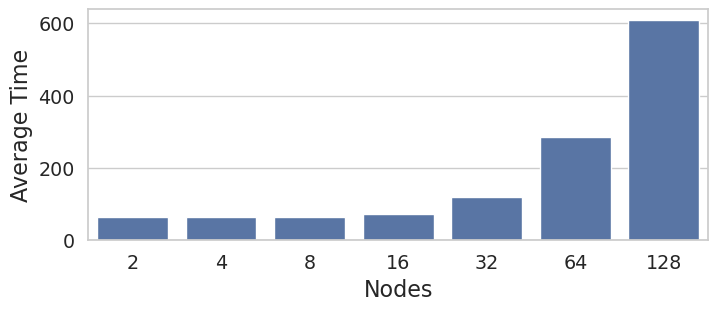

In [71]:
fig, axes = plot_time_vs_tasks(128, modules=["tensorflow"], sleep=0, method="file_system")
axes[0].get_legend().remove()
axes[0].set_title(None)
axes[0].set_xlabel("Nodes", fontsize=16)
axes[0].set_ylabel("Average Time", fontsize=16)
fig.set_size_inches(8, 3)
plt.savefig("figs/theta_demo_import.pdf", bbox_inches="tight")

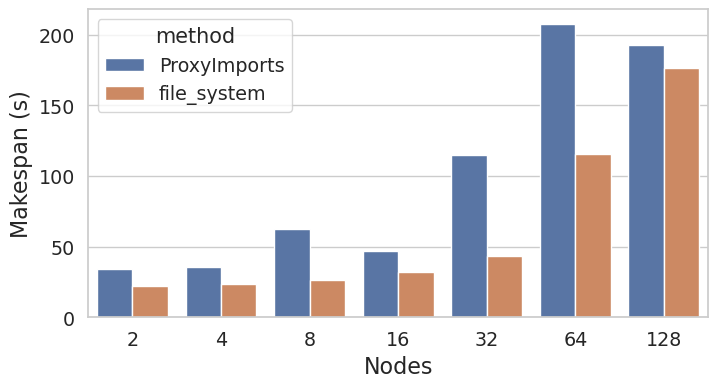

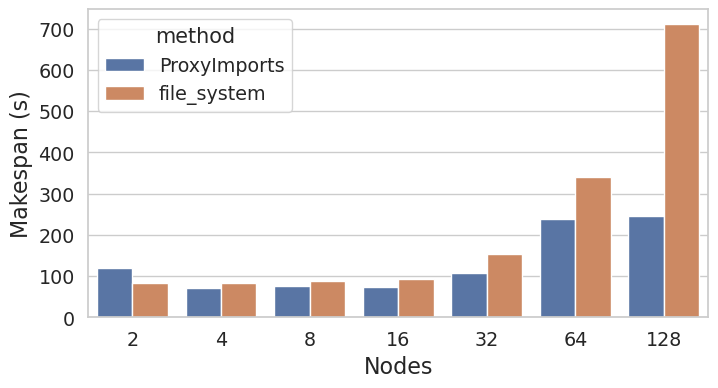

In [72]:
for module in ["numpy", "tensorflow"]:
    fig, axes = plot_time_vs_tasks(128, modules=[module], y="end_time", sleep=0)
#     axes[0].get_legend().remove()
    axes[0].set_xlabel("Nodes", fontsize=16)
    axes[0].set_ylabel("Makespan (s)", fontsize=16)
    fig.set_size_inches(8, 4)
    plt.savefig(f"figs/theta_import_sleep_0_{module}.pdf", bbox_inches="tight")
    plt.show()

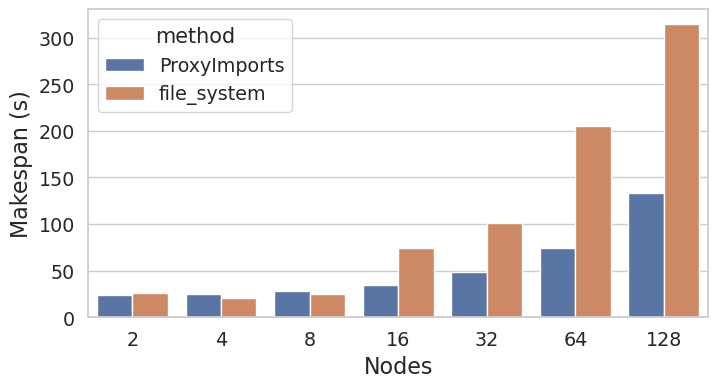

In [78]:
with open("../results/theta/results-128-numpy.jsonl") as fp:
    lines = fp.readlines()
experiments = [json.loads(line) for line in lines]
results = pd.DataFrame.from_records(experiments)
results.loc[results["method"] == "lazy", "method"] = "ProxyImports"

results["avg_time"] = results["times"].apply(lambda x: np.mean(x))
results["total_time"] = results["end_time"] + results["setup"]
results["tasks_per_node"] = results["ntasks"] / results["nodes"]
results["nodes_used"] = (results["ntasks"] / 64).astype(np.int32)

fig, axes = plot_time_vs_tasks(128, modules=["numpy"], y="end_time", sleep=0)
#     axes[0].get_legend().remove()
axes[0].set_xlabel("Nodes", fontsize=16)
axes[0].set_ylabel("Makespan (s)", fontsize=16)
fig.set_size_inches(8, 4)
plt.savefig(f"figs/theta_import_sleep_0_numpy.pdf", bbox_inches="tight")
plt.show()

In [3]:
with open("../results/theta/results-simulated.jsonl") as fp:
    lines = fp.readlines()
experiments = [json.loads(line) for line in lines]
results = pd.DataFrame.from_records(experiments)
results

,ntasks,cumulative_time,times,launch_time,end_time,method,module,nodes,sleep,setup,package_size
0,8192,1.712831e+03,"[0.3284888389753178, 0.08890914393123239, 0.08...",6.525956,249.831874,lazy,sim_pack,128,0,0.362980,1
1,8192,8.476440e+04,"[5.2965283980593085, 5.34317161294166, 5.28860...",6.637083,131.419164,file_system,sim_pack,128,0,0.050512,1
2,8192,7.378807e+02,"[0.0853928909637034, 0.08898740203585476, 0.08...",6.326862,208.355199,lazy,sim_pack,128,0,0.614112,2
3,8192,1.963639e+05,"[14.926464300020598, 14.951325573027134, 14.93...",6.165972,134.529303,file_system,sim_pack,128,0,0.003160,2
4,8192,8.127254e+02,"[0.08849434496369213, 0.09114250994753093, 0.0...",6.262670,194.643497,lazy,sim_pack,128,0,0.893028,3
5,8192,4.554419e+05,"[32.81647535599768, 32.56461119593587, 32.5498...",6.436844,193.169920,file_system,sim_pack,128,0,0.002497,3
6,8192,7.896634e+02,"[0.08938309492077678, 0.09418789099436253, 0.0...",6.416602,199.573569,lazy,sim_pack,128,0,1.115109,4
7,8192,3.967499e+05,"[36.0497065319214, 36.096182137029245, 35.9602...",6.368660,159.065603,file_system,sim_pack,128,0,0.002909,4
8,8192,2.560787e+03,"[0.08513725700322539, 0.10121082596015185, 0.1...",6.261406,228.169796,lazy,sim_pack,128,0,1.347269,5
9,8192,5.246595e+05,"[39.9660270169843, 40.01346645806916, 39.89896...",6.553389,170.037827,file_system,sim_pack,128,0,0.002951,5


Text(0.5, 1.0, 'Simulated Package')

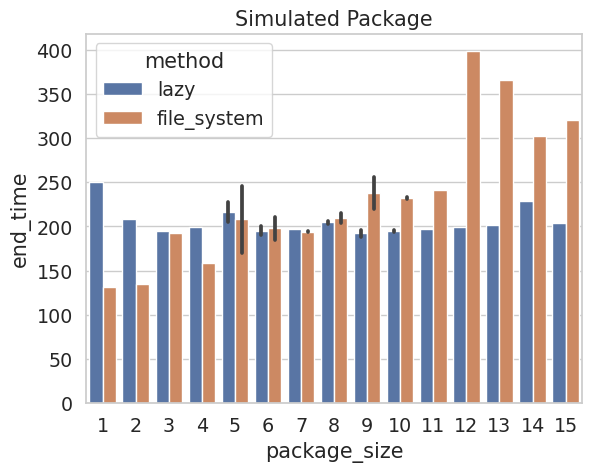

In [4]:
sns.barplot(data=results, x="package_size", y="end_time", hue="method")
plt.title(f"Simulated Package")

In [5]:
with open("../results/theta/xtb_results.jsonl") as fp:
    lines = fp.readlines()
experiments = [json.loads(line) for line in lines]
results = pd.DataFrame.from_records(experiments)
results

,method,nodes,initial,count,batch,time
0,lazy,128,8192,32768,8192,722.122494
1,file_system,128,8192,32768,8192,720.595473
2,lazy,128,8192,32768,8192,643.533692
3,file_system,128,8192,32768,8192,651.080552
4,lazy,128,8192,32768,8192,640.375646
5,file_system,128,8192,32768,8192,639.346474
6,lazy,128,8192,32768,8192,670.661413
7,file_system,128,8192,32768,8192,917.527162


Text(0.5, 1.0, 'XTB')

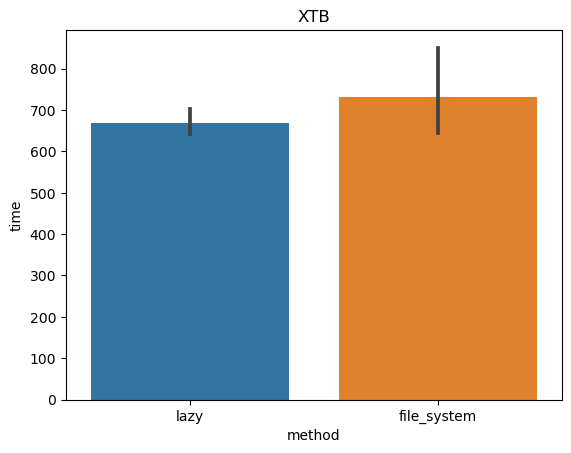

In [12]:
sns.barplot(data=results, x="method", y="time")
plt.title(f"XTB")
# plt.gcf().suptitle(f"{y} for nodes: {nodes}")

In [13]:
speedup = results[results["method"] == "file_system"]["time"].mean() / results[results["method"] == "lazy"]["time"].mean() 
print("Overall Speedup: ", speedup)

Overall Speedup:  1.094092371642059


In [85]:
with open("../results/theta/ml_results.jsonl") as fp:
    lines = fp.readlines()
experiments = [json.loads(line) for line in lines]
results = pd.DataFrame.from_records(experiments)
results.loc[results["method"] == "lazy", "method"] = "ProxyImports"
results = pd.concat([results[results["method"] == "ProxyImports"], results[results["method"] == "file_system"]])
results

,ntasks,launch_time,end_time,method,nodes,workers
30,64,18.456596,133.718464,ProxyImports,16,64
31,64,17.644374,98.207979,ProxyImports,16,64
32,64,18.049521,114.868459,ProxyImports,16,64
33,64,18.850654,95.324262,ProxyImports,16,64
34,64,17.643848,115.498022,ProxyImports,16,64
35,64,18.451040,123.434672,ProxyImports,16,64
36,64,18.376606,118.580852,ProxyImports,16,64
37,64,18.159591,114.719852,ProxyImports,16,64
38,64,18.191654,95.370044,ProxyImports,16,64
39,64,18.533587,115.438476,ProxyImports,16,64


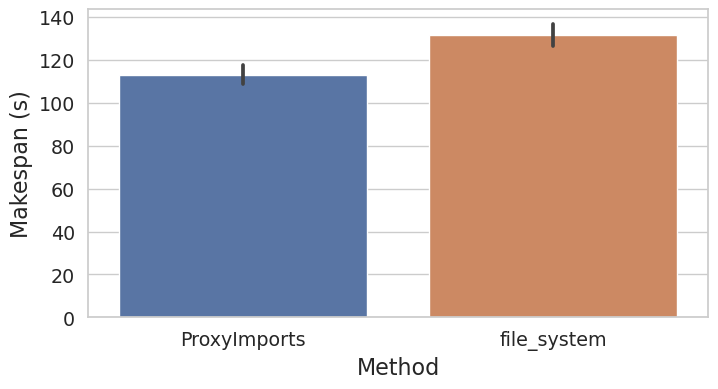

In [86]:
fig, axes = plt.subplots(figsize=(8, 4))
sns.barplot(data=results, x="method", y="end_time", errorbar="ci", ax=axes)
axes.set_xlabel(f"Method", fontsize=16)
axes.set_ylabel(f"Makespan (s)", fontsize=16)
# plt.title(f"ML Inference", fontsize=16)
plt.savefig("figs/theta_ml_exp.pdf", bbox_inches="tight")

In [15]:
results[results["method"] == "lazy"]["end_time"].describe()

count     19.000000
mean     113.177788
std       10.058832
min       95.324262
25%      114.751036
50%      115.281918
75%      117.146273
max      133.718464
Name: end_time, dtype: float64

In [16]:
results[results["method"] == "file_system"]["end_time"].describe()

count     30.000000
mean     131.635825
std       14.816234
min      111.649945
25%      115.457323
50%      141.115382
75%      144.466831
max      151.169749
Name: end_time, dtype: float64

In [82]:
with open("../results/theta/cloud_bursting.jsonl") as fp:
    lines = fp.readlines()
experiments = [json.loads(line) for line in lines]
results = pd.DataFrame.from_records(experiments)
results["method"] = results["method"].fillna("ProxyImports from Theta")
results.loc[results["method"] == "file_system", "method"] = "Locally Installed"
results

,import_time,rtt,package_size,method
0,0.539003,2.619483,1,ProxyImports from Theta
1,1.018202,1.961415,2,ProxyImports from Theta
2,1.488016,2.454412,3,ProxyImports from Theta
3,2.027393,4.601175,4,ProxyImports from Theta
4,2.730750,4.662676,5,ProxyImports from Theta
...,...,...,...,...
206,0.639474,1.087903,10,Locally Installed
207,0.656172,1.510989,10,Locally Installed
208,0.653964,1.603287,10,Locally Installed
209,0.651388,1.671992,10,Locally Installed


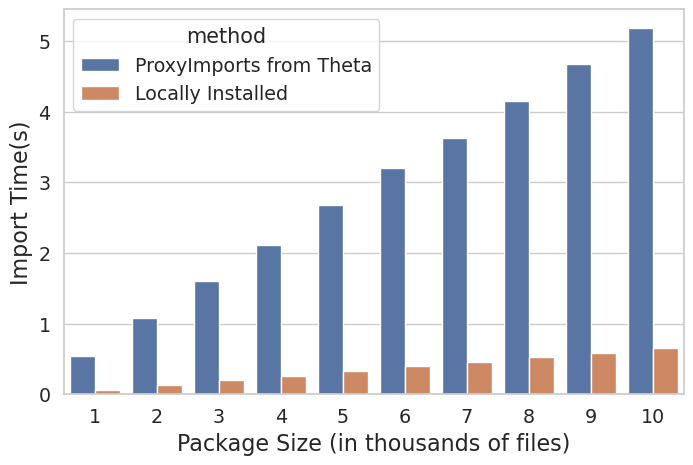

In [83]:
fig, axes = plt.subplots()
sns.barplot(data=results, x="package_size", y="import_time", hue="method", errorbar=None, ax=axes)
# axes.get_legend().remove()
axes.set_title(None)
axes.set_xlabel("Package Size (in thousands of files)", fontsize=16)
axes.set_ylabel("Import Time(s)", fontsize=16)
fig.set_size_inches(8, 5)

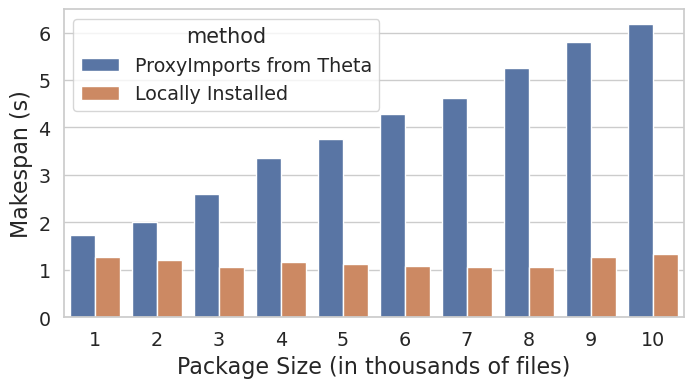

In [84]:
fig, axes = plt.subplots()
sns.barplot(data=results, x="package_size", y="rtt", hue="method", errorbar=None, ax=axes)
# axes.get_legend().remove()
axes.set_title(None)
axes.set_xlabel("Package Size (in thousands of files)", fontsize=16)
axes.set_ylabel("Makespan (s)", fontsize=16)
fig.set_size_inches(8, 4)
plt.savefig("figs/theta_to_cloud.pdf", bbox_inches="tight")